# Sentence Splitting
This notebook uses OCRed text for a volume year and splits it into sentences using regular expression pattern matching.<br>
For this notebook to run, there should be an OCRed folder that should contain a .txt file, a .tsv file, and an images sub-folder (more details in the notebook).

<b>Note:</b>
- If the Acts and Joints were mixed for the chosen year, the OCRed output will contain `{year}_Both.txt` and `{year}_Both_data.tsv`
- If the Acts and Joints were seperate for the chosen year, the OCRed output will contain `{year}_Acts.txt` and `{year}_Acts_data.tsv`

In [1]:
from nltk.tokenize import PunktSentenceTokenizer
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import re

pd.set_option('display.max_colwidth', None)

<br>
Either get the year variable from elsewhere (such as when this notebook is accessed from another file) or specify the year.

In [2]:
# Get the year variable from somewhere else
%store -r year

In [3]:
# # If running this notebook independently,
# # Uncoment the following line of code
# year = 1893

In [4]:
# This is the directory that will contain the OCRed output:
dir_OCR = "/Users/nitingupta/Desktop/OTB/OCRed/" + str(year)

print(f"Working on {year} under {dir_OCR}")

Working on 1893 under /Users/nitingupta/Desktop/OTB/OCRed/1893


In [5]:
# Try reading in "{year}_text.txt" if the Acts and Joints were seperate for the year
try:
    acts_path = dir_OCR + "/" + str(year) + "_Acts.txt"
    with open(acts_path, 'r') as f:
        data = f.read()

    # If the read is successful, set a flag that identifies that the Acts and Joints are seperate
    actsSep = True

# However, if the directory contains {year}_Both.txt instead, a FileNotFoundError will be returned for the above code.
# So, catch that error and read in "{year}_Both.txt"
except FileNotFoundError:
    acts_path = dir_OCR + "/" + str(year) + "_Both.txt"
    with open(acts_path, 'r') as f:
        data = f.read()
    
    actsSep = False  # The flag being False means that the Acts and Joints are not seperate

# This variable holds all the OCRed text as a String
# data

In [6]:
print("The number of pages OCRed for {year} is: {count}".format(year = year, count = (data.count("\n\n")+1)))

The number of pages OCRed for 1893 is: 310


<br>

## A. Training the tokenizer
Based on this [article](https://subscription.packtpub.com/book/application-development/9781782167853/1/ch01lvl1sec12/training-a-sentence-tokenizer),
- NLTK's default sentence tokenizer is general purpose and usually works quite well. But sometimes it might not be the best choice for our text if it uses nonstandard punctuation or is formatted in a unique way. In such cases, training your own sentence tokenizer can result in much more accurate sentence tokenization.
- The `PunktSentenceTokenizer` class uses an unsupervised learning algorithm to learn what constitutes a sentence break.
    - The specific technique used in this case is called sentence boundary detection. It works by counting punctuation and tokens that commonly end a sentence, such as a period or a newline, then using the resulting frequencies to decide the sentence boundaries.

In [7]:
sent_tokenizer = PunktSentenceTokenizer(data)
sentences = sent_tokenizer.tokenize(data)

# A List of tokens/sentences as seperated by nltk's PunktSentenceTokenizer
# sentences

<br>

## B. Creating the dataframe
Make a new dataframe with the sentences and character lengths as attributes

In [8]:
# Add to a new DataFrame
df = pd.DataFrame()
df["sentence"] = sentences

In [9]:
df["length"] = [len(sentence) for sentence in sentences]
print("Length of the initial dataframe:", df.shape[0], "\nThis is the number of tokenized sentences.")

Length of the initial dataframe: 2386 
This is the number of tokenized sentences.


<br>

## C. Adding page file names
- Add an feature that specifies which page number that sentence starts and ends on.
- Reading only Acts. <b> Not reading Joints </b>
- The reason to read the files from the directory is to ensure that missing file pages are not missed in the dataframe.

In [10]:
# This is the path to the directory that contains the images.
# NOTE: This directory is inside the OCRed output for the chosen year
dir_imgs = dir_OCR + "/images"
print(f"The images directory is {dir_imgs}")

The images directory is /Users/nitingupta/Desktop/OTB/OCRed/1893/images


In [11]:
imgs = os.listdir(dir_imgs)
imgs = [img for img in imgs if "jpg" in img or "tiff" in img or "JPG" in img or "TIFF" in img]
imgs.sort()
print("The number of image files for this year is:", len(imgs))

The number of image files for this year is: 390


In [12]:
fileType = imgs[0].split(".")[1]
print(f"The files are of type: {fileType}")

The files are of type: jpg


<b>Note:</b>
- The OCR attempts to seperates new pages by adding "\n\n". However, the total number of pages does not equal the total count of "\n\n" in the text as the OCR does not add "\n\n" after every page.
- One way to eliminate this issue is by utilizing the `{year}_Both_data.tsv` (if acts and joints mixed) or `{year}_Acts_data.tsv` (if acts and joints seperated) file from the OCR output.
- This file contains each word (in the 2nd last column) and the filename for that word (last column).
- Also, since we are only working with Acts, if the Acts and Joints are seperate, the last word in the df_word dataframe will not end on the actual last page in the images sub-folder.

In [13]:
# Based on whether the Acts and Joints are mixed, read the appropriate tsv file
if actsSep:
    df_words = pd.read_table(f"{dir_OCR}/{year}_Acts_data.tsv")
else:
    df_words = pd.read_table(f"{dir_OCR}/{year}_Both_data.tsv")

df_words

,left,top,width,height,conf,text,name
0,0,0,1600,872,-1.000000,NaN,035.jpg
1,221,233,1153,34,-1.000000,NaN,035.jpg
2,221,233,1153,34,-1.000000,NaN,035.jpg
3,221,233,1153,34,-1.000000,NaN,035.jpg
4,221,234,65,32,95.975761,AN,035.jpg
...,...,...,...,...,...,...,...
161733,482,2290,181,49,92.858215,"December,",343.jpg
161734,706,2286,63,73,61.019432,thy],343.jpg
161735,781,2290,37,47,60.069050,d-,343.jpg
161736,837,2290,40,31,80.572922,D.,343.jpg


So, to label the page numbers in the dataframe, we can go through the original dataframe and find the start and end words in each sentence.
<br>We, can then find the page numbers for those words, from `df_words` and add them to the original dataframe, `df`.
<br>To start, we need to clean the two dataframes.

In [14]:
df['page'] = np.nan

# Drop the columns which are unessecary for our analysis
df_words.drop(columns=["left", "top", "width", "height", "conf"], inplace=True)

# Drop the rows which don't contain a word in the "text" column
df_words.dropna(inplace=True)

# Relabel the "name" column to "page" column
df_words.rename(columns={"name": "page"}, inplace=True)

# Reassign index after dropping nas
df_words = df_words.assign(row_number=range(len(df_words)))
df_words.set_index('row_number', inplace=True)

# Drop the 'page' column from the org dataframe
df.drop(columns=['page'], inplace=True)

# Add an empty 'start_page' and 'end_page' column
df['start_page'] = np.nan
df['end_page'] = np.nan

Since, a word can only exist on a single page, we have unique identifiers for the start and end page for each sentence 

In [15]:
# Tracker for df_words:
words_trkr = 0

# Loop over the original dataframe
for i in range(0, df.shape[0]):
    
    # Remove "\n\n" from the original dataframe as they will interfere with the analysis
    df.at[i, 'sentence'] = df.iloc[i]['sentence'].replace("\n\n", "")

    # For each sentence, extract the first and last word
    tmp_sentence = df.iloc[i]['sentence'].split(" ")
    start, last = tmp_sentence[0], tmp_sentence[-1]

    # Get the page number for the start and end word
    start_page = df_words.iloc[words_trkr]['page']

    try:
        end_page = df_words.iloc[words_trkr + len(tmp_sentence)]['page']
    except:
        end_page = df_words.iloc[words_trkr]['page']
        

    # Remove the filename from the pages:
    start_page = start_page.split(".")[0]
    end_page = end_page.split(".")[0]

    
    # Assign the page number to their respective columns in the dataframe
    df.at[i, 'start_page'] = start_page
    df.at[i, 'end_page'] = end_page
    
    # Update tracker
    words_trkr += len(tmp_sentence)

In [16]:
df.tail(10)

,sentence,length,start_page,end_page
2376,"Section 1. Be tt enacted by the Senate and House of Repre- resentatives of the State of South Carolina, now met and sitting in General Assembly, and by the authority of the same, That the charter of the Clover Manufaeturing Company, chartered as a corporation by a certificate of incorporation issued by the Sec- Secretary of State of the State of South Carolina, dated the 20th day of January, A. D. 1890, be, and the same is hereby, amended so as to enable the said company to buy, sell and do a general mercantile business.",526,343,343
2377,"under the name of Clover Cotton Manufac- turing Company: Provided, Not more than $5,000 of funds belonging to said compuny shall at any time be employed in said business ; nor shall said company at any one time ineur liability or liabilities in reference thereto to a greater amount than five thousand (#5,000) dollars.",319,343,343
2378,Sec.,4,343,343
2379,"2. That the charter of said company as hereby amended be, and the same is hereby, contirmed, with all the rights, privi- leges and powers conferred on private incorporations formed for the purpose of carrying on any manufacturing, mining, indus- trial, labor, immigration or other business, except for railroad purposes, under an Act entitled ‘An Act to provide for the formation of certain corporations under general laws,” approved 23d December.",447,343,343
2380,18x86.,6,343,343
2381,"Approved January 4th, A. D. 1894.",33,343,343
2382,{This Joint Resolution was inadvertently omitted from its proper place among the foregoing Acts and Joint Resolutions.],119,343,343
2383,A JOINT RESOLUTION to AvTHORIZE AND EMPOWER THE StaTE House Commission TO PROVIDE A SUITABLE OFFICE FOR THE STATE SUPERINTENDENT OF EDUCATION AND TO FURNI3H THE SAME.,166,343,343
2384,"SEcTION 1. Be it resulved by the Senate and House of Repre- sentatives of the State of South Carolina, now met and sitting in General Assembly, and by the authority of the same, That the State House Commission be, and they are hereby, authorized and empowered, if practicable, to furnish the office of the State Superintendent of Education with all suitable and necessary furniture and shelving for the keeping and preservaticn of the records of his office.",457,343,343
2385,"Approved December, thy] d- D. 1893.",35,343,343


<br>

## D. Cleaning on Char. lenght
Get rid of sentences with a low number of characters as they might not form meaningful sentences.

However, first, get the statistics on the length column to avoid removing meaningful sentences.

In [17]:
# Get the statistics for the length column
df["length"].describe()

count    2386.000000
mean      294.446354
std       394.048534
min         1.000000
25%         4.000000
50%       171.000000
75%       407.000000
max      4545.000000
Name: length, dtype: float64

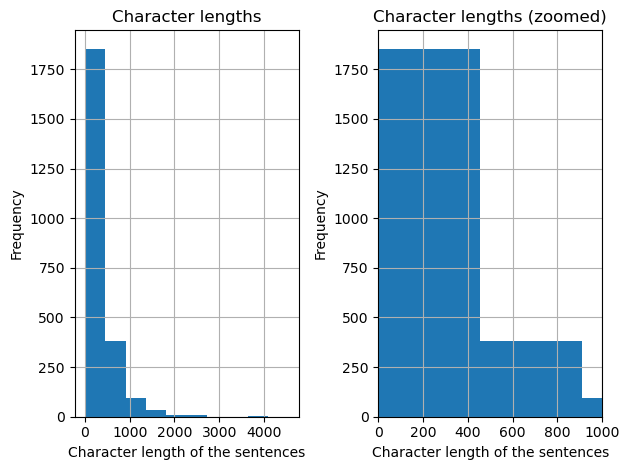

In [18]:
# Plot a histogram for that column
fig, axes = plt.subplots(1, 2)
df.hist(column="length", ax=axes[0])
axes[0].set_title('Character lengths')
axes[0].set(xlabel="Character length of the sentences", ylabel="Frequency")

df.hist(column="length", ax=axes[1])

axes[1].set_title('Character lengths (zoomed)')
axes[1].set(xlabel="Character length of the sentences", ylabel="Frequency", xlim = [0, 1000])
fig.tight_layout()

Define a cutoff for the sentences. All sentences belows this length will be removed

In [19]:
cut_len = 50

Create a smaller dataframe, and export it to csv, that only contains the short length sentences.
Check the csv and change the length condition accordingly.

In [20]:
# # Uncomment the following line of code to create the csv which contains the short length sentences.

# testing_df = df[df['length'] < cut_len]
# testing_df.to_csv(f"{year}_len_testing.csv", index=False)

<br>
Once, the length is decided, create a new dataframe with sentences greater that the length

In [21]:
df_reduced = df[ df["length"] > cut_len]
print("Length of the cleaned dataframe: ", df_reduced.shape[0])
print("Reduction of about {:.2f}%".format( (1 - df_reduced.shape[0]/df.shape[0]) * 100))

Length of the cleaned dataframe:  1614
Reduction of about 32.36%


In [22]:
df_reduced.reset_index(drop=True, inplace=True)
df_reduced.index.name = "index"

<br>

## E. Further Cleaning and Regex
Remove unecessary words in the sentences which do not contribute to the overall meaning.

In [23]:
# New dataframe so that the results of the matching can be compared
df_cleaned = df_reduced.copy()

# A new dictionary to keep track of the number of errors
errorsDict = {}

In [24]:
# Create a new column that will contain the removed words that match the section patter
df_cleaned['removed'] = np.nan

# Rename 'sentence' column to 'org_sent' to avoid confusion
df_cleaned.rename(columns={'sentence': 'org_sent'}, inplace=True)

In [25]:
df_cleaned.head()

,org_sent,length,start_page,end_page,removed
index,,,,,
0,"AN ACT To PRovIDE FoR THE FORFEITURE OF THE CHARTER or ANY CORPORATION CREATED UNDER THE Laws OF Tuis State WHENEVER SucH CoRPORATION SHALL RE- FUSE, NEGLECT OR OmIT TO Pay THE TAXES AS ASSESSED AND LEVIED Upon THE PROPERTY OF SuCH CORPORATION FOR STATE AND CouNnTYy PURPOSES.",278,035,035,NaN
1,"~ SECTION 1. Be ié enacted by the Senate and House of Repre- sentatives of the State of South Carolina, now met and sitting in General Assembly, and by the authority of the same, That when- ever any corporation chartered under the laws of this State shall, within thirty days after the time required and permitted by law for taxes to be paid, with or without penalty, as now required by law, refuse, neglect or omit to pay the taxes for State and County purposes, as assessed and levied upon the property of such corpo- ration, the charter of such corporation, with all the rights, privi- leges and franchises thereunder, shall become and be deemed forfeited, and the corporate existence of such corporation shall be annulled.",728,035,036,NaN
2,"2. That in every such case it shall be the duty of the Attorney-General, and he is hereby required, to bring an action against such corporation for the purpose of vacating and annull- ing the Act incorporating such corporation and all Acts amenda- tory or in renewal thereof, in the manner prescribed by Title XIII., Chapter I., of the Code of Civil Procedure of this State.",374,036,036,NaN
3,"3, That this Act shall be deemed a public Act, and shall go into effect immediately upon the approval thereof.",110,036,036,NaN
4,"Approved December 18th, A. D. 1893. AN ACT FoR THE PROTECTION OF THE AIDS TO NAVIGATION EsTABLISHED BY THE AUTHORITY OF THE UNITED STATES LicgHt Hovust BoarD WITHIN THE STATE OF SOUTH CARO- LINA.",195,036,036,NaN


In [26]:
def replaceInDF(rgx_match: re.Pattern, df: pd.DataFrame, prevAppend: bool):
    '''
    Find the provided regex pattern in the provided dataframe.
    
    Parameters
    ----------
    rgx_match : re.Pattern
        A regular expression pattern that will be search for and replaced in the df
    df: pandas.Dataframe
        A Pandas dataframe to search and replace for
        Should contain an:
            'org_sent' column, in which the matches which will be replaced
             'removed' column, in which the matched string will be stored
     prevAppend: bool
         A flag for whether the match should be append to the end of the previous sentence
        
    Returns
    -------
    A tuple consisting of:
    
    df: pandas.Dataframe
        The modified Dataframe with the matches performed
    errorCount: int
        A count of how many times this error was found.
    '''
    
    errorCount = 0
    
    for i in range(0, df.shape[0]):
    
        # The value at this row's "removed" column
        removed_val = df.iloc[i]['removed']
        
        # The found matches
        matches = "; ".join([x.group() for x in re.finditer(rgx_match, df.iloc[i]['org_sent'])])
        
        # if no match found...
        if not matches:
            continue

        # Else if match is found...
        
        # Update the counter for the error with the number of matches found
        errorCount += len(matches.split(";"))
        
        # Check if there is already a value in the 'removed' column for that row
        if removed_val != "" and not pd.isnull(removed_val):
            # Append the matches to the existing value seperated by ";"
            df.at[i, 'removed'] = str(removed_val) + "; " + matches
        else:
            # Add the matched patterns to the "removed" section seperated by ";"
            df.at[i, 'removed'] = matches
        
        if prevAppend and i != 0:
            
            m = re.search(rgx_match, df.iloc[i]['org_sent'])
            if m:
                # Add to the end of the previous sentence
                df.at[i-1, 'org_sent'] = df.iloc[i-1]['org_sent'] + " " + str(m.group())
            
        # Remove the matched patterns from sentences
        df.at[i, 'org_sent'] = re.sub(rgx_match, '', df.iloc[i]['org_sent'])    
        
    return df, errorCount

<br>

### 1. Removing section identifiers
The following code implements regex patterns to identify sections, such as "Section 1.", "Sec. 4.", etc. 
<br>Since most sections, which need to be removed, appear either at the start or the start of the ORCed sentence, the pattern finds matches either at the start or the end of the sentence.
<br>Do note that the same pattern is repeated for the start and end of the sentence, and is seperated by '|'.

Some notes about the pattern:
- `r'(S|s|E|e|C|c|T|t|I|i|O|o|N|n){2,}'` matches "Section"
- `r'(\.|,|:|;| )'{0,2}` matches mistaken delimiters or spaces following "Section"
- `r'[0Oo1Iil!2Z5S6G\d]{1,2}'` matches the section number. Letters are required in this pattern to account for OCR mistakes
- `r'(. |.| |)'` matches the end of phrase spaces and periods

In [27]:
rgx_match = re.compile(r"^(S|s|E|e|C|c|T|t|I|i|O|o|N|n){2,}(\.|,|:|;| ){0,2}[0Oo1Iil!2Z5S6G\d]{1,2}(. |.| |)|(S|s|E|e|C|c|T|t|I|i|O|o|N|n){2,}(\.|,|:|;| ){0,2}[0Oo1Iil!2Z5S6G\d]{1,2}(. |.| |)$")

df_cleaned, errorsDict['section identifiers'] = replaceInDF(rgx_match, df_cleaned, False)

In [28]:
df_cleaned.head(10)

,org_sent,length,start_page,end_page,removed
index,,,,,
0,"AN ACT To PRovIDE FoR THE FORFEITURE OF THE CHARTER or ANY CORPORATION CREATED UNDER THE Laws OF Tuis State WHENEVER SucH CoRPORATION SHALL RE- FUSE, NEGLECT OR OmIT TO Pay THE TAXES AS ASSESSED AND LEVIED Upon THE PROPERTY OF SuCH CORPORATION FOR STATE AND CouNnTYy PURP",278,035,035,OSES.
1,"~ SECTION 1. Be ié enacted by the Senate and House of Repre- sentatives of the State of South Carolina, now met and sitting in General Assembly, and by the authority of the same, That when- ever any corporation chartered under the laws of this State shall, within thirty days after the time required and permitted by law for taxes to be paid, with or without penalty, as now required by law, refuse, neglect or omit to pay the taxes for State and County purposes, as assessed and levied upon the property of such corpo- ration, the charter of such corporation, with all the rights, privi- leges and franchises thereunder, shall become and be deemed forfeited, and the corporate existence of such corporation shall be annulled.",728,035,036,NaN
2,"2. That in every such case it shall be the duty of the Attorney-General, and he is hereby required, to bring an action against such corporation for the purpose of vacating and annull- ing the Act incorporating such corporation and all Acts amenda- tory or in renewal thereof, in the manner prescribed by Title XIII., Chapter I., of the Code of Civil Procedure of this State.",374,036,036,NaN
3,"3, That this Act shall be deemed a public Act, and shall go into effect immediately upon the approval thereof.",110,036,036,NaN
4,"Approved December 18th, A. D. 1893. AN ACT FoR THE PROTECTION OF THE AIDS TO NAVIGATION EsTABLISHED BY THE AUTHORITY OF THE UNITED STATES LicgHt Hovust BoarD WITHIN THE STATE OF SOUTH CARO- LINA.",195,036,036,NaN
5,"Be tt enacted by the Senate and House of Repre- sentatives of the State of South Carolina, now met and sitting in General Assembly, and by the authority of the same, That any person or persons who shall moor any vessel or vessels of any kind or name whatsoever, or any raft or any part of a raft, to any buoy, beacon or day mark placed in the waters of South Caro- lina by the authority of the United States Light House Board, or shall in any manner hang on with any vessel or raft, or part of araft, to any such buoy, beacon or day mark, or shall will- fully remove, damage or destroy any beacon or beacons erected on lands in this State by the authority of the said United States Light House Board, or having, through unavoidable accident, run down, dragged from its position, or in any way injured any buoy, beacon or day mark as aforesaid, and shall fail to give notice as soon as practicable of having done so to the Light House Inspec- tor of the district in which said buoy, beacon or day mark may be located, or to the Board of Wardens for the Port of South Carolina, shall, for every such offense, be deemed guilty of at misdemeanor, and upon conviction thereof before any Court of competent jurisdiction shall be punished by a fine not to exceed two hundred dollars or imprisonment not to exceed three months, or both, at the discretion of the Court; one-third of the fine in each case shall be paid to the informer and two-thirds thereof to the Light House Board, to be used in repairing the said buoys or beacons.",1538,036,037,SECTION 1.
6,"It shall be unlawful for any vessel to anchor on the range line of any range lights established by the United States Light House Board in this State, and the master of any vessel so anchoring shall be deemed guilty of a misdemeanor, and upon conviction thereof before any Court of competent jurisdiction shall be punished by a fine not to exceed fifty dollars, one-half of the fine in each case to be paid to the informer and one-half to the State.",448,037,037,NaN
7,"The cost of repairing or replacing any such buoy, bea- con or day mark which may have been misplaced, damaged or destroyed by any vesse

<br>

### 2. Removing end of line hyphenation
Whenever a word in the sentence continues from the end of a line to the beginning of the next line and is joined by a hyphen, the OCRed sentence also contains that hyphen and a space.
<br>For example, 'Commander-in-Chief' is OCRed as 'Com- mander-in-Chief'
<br>The following code implements regex patterns to remove "- " in the text since each hyphenated word is split with "- ".

In [29]:
rgx_match = re.compile('[-][ ]')
df_cleaned, errorsDict['EOL hyphenation'] = replaceInDF(rgx_match, df_cleaned, False)

In [30]:
df_cleaned.head(10)

,org_sent,length,start_page,end_page,removed
index,,,,,
0,"AN ACT To PRovIDE FoR THE FORFEITURE OF THE CHARTER or ANY CORPORATION CREATED UNDER THE Laws OF Tuis State WHENEVER SucH CoRPORATION SHALL REFUSE, NEGLECT OR OmIT TO Pay THE TAXES AS ASSESSED AND LEVIED Upon THE PROPERTY OF SuCH CORPORATION FOR STATE AND CouNnTYy PURP",278,035,035,OSES.; -
1,"~ SECTION 1. Be ié enacted by the Senate and House of Representatives of the State of South Carolina, now met and sitting in General Assembly, and by the authority of the same, That whenever any corporation chartered under the laws of this State shall, within thirty days after the time required and permitted by law for taxes to be paid, with or without penalty, as now required by law, refuse, neglect or omit to pay the taxes for State and County purposes, as assessed and levied upon the property of such corporation, the charter of such corporation, with all the rights, privileges and franchises thereunder, shall become and be deemed forfeited, and the corporate existence of such corporation shall be annulled.",728,035,036,- ; - ; - ; -
2,"2. That in every such case it shall be the duty of the Attorney-General, and he is hereby required, to bring an action against such corporation for the purpose of vacating and annulling the Act incorporating such corporation and all Acts amendatory or in renewal thereof, in the manner prescribed by Title XIII., Chapter I., of the Code of Civil Procedure of this State.",374,036,036,- ; -
3,"3, That this Act shall be deemed a public Act, and shall go into effect immediately upon the approval thereof.",110,036,036,NaN
4,"Approved December 18th, A. D. 1893. AN ACT FoR THE PROTECTION OF THE AIDS TO NAVIGATION EsTABLISHED BY THE AUTHORITY OF THE UNITED STATES LicgHt Hovust BoarD WITHIN THE STATE OF SOUTH CAROLINA.",195,036,036,-
5,"Be tt enacted by the Senate and House of Representatives of the State of South Carolina, now met and sitting in General Assembly, and by the authority of the same, That any person or persons who shall moor any vessel or vessels of any kind or name whatsoever, or any raft or any part of a raft, to any buoy, beacon or day mark placed in the waters of South Carolina by the authority of the United States Light House Board, or shall in any manner hang on with any vessel or raft, or part of araft, to any such buoy, beacon or day mark, or shall willfully remove, damage or destroy any beacon or beacons erected on lands in this State by the authority of the said United States Light House Board, or having, through unavoidable accident, run down, dragged from its position, or in any way injured any buoy, beacon or day mark as aforesaid, and shall fail to give notice as soon as practicable of having done so to the Light House Inspector of the district in which said buoy, beacon or day mark may be located, or to the Board of Wardens for the Port of South Carolina, shall, for every such offense, be deemed guilty of at misdemeanor, and upon conviction thereof before any Court of competent jurisdiction shall be punished by a fine not to exceed two hundred dollars or imprisonment not to exceed three months, or both, at the discretion of the Court; one-third of the fine in each case shall be paid to the informer and two-thirds thereof to the Light House Board, to be used in repairing the said buoys or beacons.",1538,036,037,SECTION 1. ; - ; - ; - ; -
6,"It shall be unlawful for any vessel to anchor on the range line of any range lights established by the United States Light House Board in this State, and the master of any vessel so anchoring shall be deemed guilty of a misdemeanor, and upon conviction thereof before any Court of competent jurisdiction shall be punished by a fine not to exceed fifty dollars, one-half of the fine in each case to be paid to the informer and one-half to the State.",448,037,037,NaN
7,"The cost of repairing or replacing any such buoy, beacon or day mark which may have been misplaced, damaged or destroyed by any ve

<br>

### 3. Relocating incorrect "Approved ..." phrases
The “Approved…” phrases are incorrectly appended to the start of the next law. They should by appended to the end of the previous law.
<br>Phrases might be of the format: 
- "Approved the 2oth day of February, A. D. 1901",
- "Approved December 15th, A. D. 1892.",
- "Approved December O5th, A. D. 1892.",
- "Approved December !2th, A. D. 1892.",
- "Approved December 6Gth, A. D. 1892.",
- "Approved December 05th, A. D. 1892.",

Since phrases might either have the month or the date after the "Approved" sub-string, the code below utilized two patterns to account for either case, seperated by '|'.
<br>
Some notes about the pattern:
- `r'[0Oo1Iil!2Z5S6G\d]{1,2}'` matches the date. Letters are required in this pattern to account for OCR mistakes
- `r'(?:th|st|nd|rd)'` matches the prefixes for the dates
- `r'[A-Z][a-z]+'` matches the month
- `r'(?:18\d{2}|19\d{2}|2\d{3})'` matches years ranging from 18** to 2***
- `r'(. |.| |)'` matches the end of phrase spaces and periods

In [31]:
rgx_match = re.compile(
    r'^Approved the [0Oo1Iil!2Z5S6G\d]{1,2}(?:th|st|nd|rd) day of [A-Z][a-z]+, A\. D\. (?:18\d{2}|19\d{2}|2\d{3})(. |.| |)\b|Approved [A-Z][a-z]+ [0Oo1Iil!2Z5S6G\d]{1,2}(?:th|st|nd|rd), A\. D\. (?:18\d{2}|19\d{2}|2\d{3})(. |.| |)\b')
df_cleaned, errorsDict['Approved phrases'] = replaceInDF(rgx_match, df_cleaned, True)

In [32]:
df_cleaned.head(10)

,org_sent,length,start_page,end_page,removed
index,,,,,
0,"AN ACT To PRovIDE FoR THE FORFEITURE OF THE CHARTER or ANY CORPORATION CREATED UNDER THE Laws OF Tuis State WHENEVER SucH CoRPORATION SHALL REFUSE, NEGLECT OR OmIT TO Pay THE TAXES AS ASSESSED AND LEVIED Upon THE PROPERTY OF SuCH CORPORATION FOR STATE AND CouNnTYy PURP",278,035,035,OSES.; -
1,"~ SECTION 1. Be ié enacted by the Senate and House of Representatives of the State of South Carolina, now met and sitting in General Assembly, and by the authority of the same, That whenever any corporation chartered under the laws of this State shall, within thirty days after the time required and permitted by law for taxes to be paid, with or without penalty, as now required by law, refuse, neglect or omit to pay the taxes for State and County purposes, as assessed and levied upon the property of such corporation, the charter of such corporation, with all the rights, privileges and franchises thereunder, shall become and be deemed forfeited, and the corporate existence of such corporation shall be annulled.",728,035,036,- ; - ; - ; -
2,"2. That in every such case it shall be the duty of the Attorney-General, and he is hereby required, to bring an action against such corporation for the purpose of vacating and annulling the Act incorporating such corporation and all Acts amendatory or in renewal thereof, in the manner prescribed by Title XIII., Chapter I., of the Code of Civil Procedure of this State.",374,036,036,- ; -
3,"3, That this Act shall be deemed a public Act, and shall go into effect immediately upon the approval thereof. Approved December 18th, A. D. 1893.",110,036,036,NaN
4,AN ACT FoR THE PROTECTION OF THE AIDS TO NAVIGATION EsTABLISHED BY THE AUTHORITY OF THE UNITED STATES LicgHt Hovust BoarD WITHIN THE STATE OF SOUTH CAROLINA.,195,036,036,"- ; Approved December 18th, A. D. 1893."
5,"Be tt enacted by the Senate and House of Representatives of the State of South Carolina, now met and sitting in General Assembly, and by the authority of the same, That any person or persons who shall moor any vessel or vessels of any kind or name whatsoever, or any raft or any part of a raft, to any buoy, beacon or day mark placed in the waters of South Carolina by the authority of the United States Light House Board, or shall in any manner hang on with any vessel or raft, or part of araft, to any such buoy, beacon or day mark, or shall willfully remove, damage or destroy any beacon or beacons erected on lands in this State by the authority of the said United States Light House Board, or having, through unavoidable accident, run down, dragged from its position, or in any way injured any buoy, beacon or day mark as aforesaid, and shall fail to give notice as soon as practicable of having done so to the Light House Inspector of the district in which said buoy, beacon or day mark may be located, or to the Board of Wardens for the Port of South Carolina, shall, for every such offense, be deemed guilty of at misdemeanor, and upon conviction thereof before any Court of competent jurisdiction shall be punished by a fine not to exceed two hundred dollars or imprisonment not to exceed three months, or both, at the discretion of the Court; one-third of the fine in each case shall be paid to the informer and two-thirds thereof to the Light House Board, to be used in repairing the said buoys or beacons.",1538,036,037,SECTION 1. ; - ; - ; - ; -
6,"It shall be unlawful for any vessel to anchor on the range line of any range lights established by the United States Light House Board in this State, and the master of any vessel so anchoring shall be deemed guilty of a misdemeanor, and upon conviction thereof before any Court of competent jurisdiction shall be punished by a fine not to exceed fifty dollars, one-half of the fine in each case to be paid to the informer and one-half to the State.",448,037,037,NaN
7,"The cost of repairing or replacing any such buoy, beacon or day mark which may have been mis

<br>

### 4. Removing Act seperators
The horizontal lines differentiating one Act from another show up as U+2014 : EM DASH characters (one or multiple) in the OCR.
<br>For example, '——- —— AN ACT...' or '—— AN ACT...'

Some notes about the pattern:
- `r'^—+'` matches one or more consecutive occurrences of the "—" character at the start of a line.
- `r'(?=\s*[A-Za-z])'` is a positive lookahead (this part isn't captured) that checks if there is zero or more whitespace characters (\s*) followed by a letter ([A-Za-z]) after the "—" characters.

In [33]:
rgx_match = re.compile(r'^—+(?=\s*[A-Za-z])')
df_cleaned, errorsDict['Act seperators'] = replaceInDF(rgx_match, df_cleaned, False)

In [34]:
df_cleaned.head()

,org_sent,length,start_page,end_page,removed
index,,,,,
0,"AN ACT To PRovIDE FoR THE FORFEITURE OF THE CHARTER or ANY CORPORATION CREATED UNDER THE Laws OF Tuis State WHENEVER SucH CoRPORATION SHALL REFUSE, NEGLECT OR OmIT TO Pay THE TAXES AS ASSESSED AND LEVIED Upon THE PROPERTY OF SuCH CORPORATION FOR STATE AND CouNnTYy PURP",278,035,035,OSES.; -
1,"~ SECTION 1. Be ié enacted by the Senate and House of Representatives of the State of South Carolina, now met and sitting in General Assembly, and by the authority of the same, That whenever any corporation chartered under the laws of this State shall, within thirty days after the time required and permitted by law for taxes to be paid, with or without penalty, as now required by law, refuse, neglect or omit to pay the taxes for State and County purposes, as assessed and levied upon the property of such corporation, the charter of such corporation, with all the rights, privileges and franchises thereunder, shall become and be deemed forfeited, and the corporate existence of such corporation shall be annulled.",728,035,036,- ; - ; - ; -
2,"2. That in every such case it shall be the duty of the Attorney-General, and he is hereby required, to bring an action against such corporation for the purpose of vacating and annulling the Act incorporating such corporation and all Acts amendatory or in renewal thereof, in the manner prescribed by Title XIII., Chapter I., of the Code of Civil Procedure of this State.",374,036,036,- ; -
3,"3, That this Act shall be deemed a public Act, and shall go into effect immediately upon the approval thereof. Approved December 18th, A. D. 1893.",110,036,036,NaN
4,AN ACT FoR THE PROTECTION OF THE AIDS TO NAVIGATION EsTABLISHED BY THE AUTHORITY OF THE UNITED STATES LicgHt Hovust BoarD WITHIN THE STATE OF SOUTH CAROLINA.,195,036,036,"- ; Approved December 18th, A. D. 1893."


<br>

### 5. Removing incorrect numbers at the start
Some numbers are incorrectly left at the start of the sentence from the OCR process. They are rather OCRed, for example, as 2, or 2.

Some notes about the pattern:
- `r'^[0Oo1Iil!2Z5S6G\d]{1,3}'` matches upto 3 numbers at the start of the string
- `r'(. |.| |)'` matches the end of phrase spaces and periods

In [35]:
rgx_match = re.compile(r'^[0Oo1Iil!2Z5S6G\d]{1,3}(. |.| |)')
df_cleaned, errorsDict['Incorrect starting nums'] = replaceInDF(rgx_match, df_cleaned, False)

In [36]:
df_cleaned.head()

,org_sent,length,start_page,end_page,removed
index,,,,,
0,"AN ACT To PRovIDE FoR THE FORFEITURE OF THE CHARTER or ANY CORPORATION CREATED UNDER THE Laws OF Tuis State WHENEVER SucH CoRPORATION SHALL REFUSE, NEGLECT OR OmIT TO Pay THE TAXES AS ASSESSED AND LEVIED Upon THE PROPERTY OF SuCH CORPORATION FOR STATE AND CouNnTYy PURP",278,035,035,OSES.; -
1,"~ SECTION 1. Be ié enacted by the Senate and House of Representatives of the State of South Carolina, now met and sitting in General Assembly, and by the authority of the same, That whenever any corporation chartered under the laws of this State shall, within thirty days after the time required and permitted by law for taxes to be paid, with or without penalty, as now required by law, refuse, neglect or omit to pay the taxes for State and County purposes, as assessed and levied upon the property of such corporation, the charter of such corporation, with all the rights, privileges and franchises thereunder, shall become and be deemed forfeited, and the corporate existence of such corporation shall be annulled.",728,035,036,- ; - ; - ; -
2,"That in every such case it shall be the duty of the Attorney-General, and he is hereby required, to bring an action against such corporation for the purpose of vacating and annulling the Act incorporating such corporation and all Acts amendatory or in renewal thereof, in the manner prescribed by Title XIII., Chapter I., of the Code of Civil Procedure of this State.",374,036,036,- ; - ; 2.
3,"That this Act shall be deemed a public Act, and shall go into effect immediately upon the approval thereof. Approved December 18th, A. D. 1893.",110,036,036,"3,"
4,AN ACT FoR THE PROTECTION OF THE AIDS TO NAVIGATION EsTABLISHED BY THE AUTHORITY OF THE UNITED STATES LicgHt Hovust BoarD WITHIN THE STATE OF SOUTH CAROLINA.,195,036,036,"- ; Approved December 18th, A. D. 1893."


<br>

### 6. Removing session headers
For some volumes, the OCRed text includes information about the session held (which is usually found on the first page).
<br>The first valid sentence starts with "An Acts ...". So, to remove them, the code removes all sentences until the first valid sentence appears

In [37]:
for i, sent in enumerate(df_cleaned['org_sent']):

    # If the sentence with "an" is found, exit the loop
    if sent.lower().strip().startswith("an"):
           break
    
    # Disregard the sentence since it does not start with "an"
    df_cleaned.drop(index=i, inplace=True)

In [38]:
# Reset the index
df_cleaned.reset_index(drop=True, inplace=True)

In [39]:
df_cleaned.head()

,org_sent,length,start_page,end_page,removed
0,"AN ACT To PRovIDE FoR THE FORFEITURE OF THE CHARTER or ANY CORPORATION CREATED UNDER THE Laws OF Tuis State WHENEVER SucH CoRPORATION SHALL REFUSE, NEGLECT OR OmIT TO Pay THE TAXES AS ASSESSED AND LEVIED Upon THE PROPERTY OF SuCH CORPORATION FOR STATE AND CouNnTYy PURP",278,035,035,OSES.; -
1,"~ SECTION 1. Be ié enacted by the Senate and House of Representatives of the State of South Carolina, now met and sitting in General Assembly, and by the authority of the same, That whenever any corporation chartered under the laws of this State shall, within thirty days after the time required and permitted by law for taxes to be paid, with or without penalty, as now required by law, refuse, neglect or omit to pay the taxes for State and County purposes, as assessed and levied upon the property of such corporation, the charter of such corporation, with all the rights, privileges and franchises thereunder, shall become and be deemed forfeited, and the corporate existence of such corporation shall be annulled.",728,035,036,- ; - ; - ; -
2,"That in every such case it shall be the duty of the Attorney-General, and he is hereby required, to bring an action against such corporation for the purpose of vacating and annulling the Act incorporating such corporation and all Acts amendatory or in renewal thereof, in the manner prescribed by Title XIII., Chapter I., of the Code of Civil Procedure of this State.",374,036,036,- ; - ; 2.
3,"That this Act shall be deemed a public Act, and shall go into effect immediately upon the approval thereof. Approved December 18th, A. D. 1893.",110,036,036,"3,"
4,AN ACT FoR THE PROTECTION OF THE AIDS TO NAVIGATION EsTABLISHED BY THE AUTHORITY OF THE UNITED STATES LicgHt Hovust BoarD WITHIN THE STATE OF SOUTH CAROLINA.,195,036,036,"- ; Approved December 18th, A. D. 1893."


<br>
<br>
<b>Note:</b> The error fixing above is not perfect and some errors are still present in the dataframe after performing these operations.
Also, some errors are too random to match and search using a pattern, and are still present in the dataframe.
<br>The output below shows the number of errors corrected for this volume:

In [40]:
errorsDict

{'section identifiers': 232,
 'EOL hyphenation': 1764,
 'Approved phrases': 108,
 'Act seperators': 9,
 'Incorrect starting nums': 656}

<br>

## F. Adding features
The features added below are:
- an id: a concatenation of the year and index number
- whether the sentence is an Act or a Joint
- the state that the law originates from

### 1. Adding ID

In [41]:
def addPrefix(fileName: str, nameLen: int, fileType: bool) -> str:
    '''
    Since the fileNames from the excel parsing could be any of any length
    (ranging from 1-3), this function appends a string of 0's to the 
    start of the input so that it is the specified nameLen lengths long.
    
    Parameters
    ----------
    fileName : str
        The file name that needs to be prefixed
    nameLen : int
        The length of the expected name of the file
        Ex. '00034.jpg' would have length of 5
        so nameLen should be 5
    fileType: bool
        True if the fileName contains a fileType prefix such as '.tiff'

    Returns
    -------
    str
        A length 5 file name (prefixed with 0's)
    '''
    
    # Remove the file type
    if fileType:
        name = fileName.split(".")[0]
    else:
        name = fileName

    prefix_length = nameLen - len(name)
    prefix = "0" * prefix_length
    
    final_string = prefix + fileName
    return final_string

In [42]:
df_cleaned.reset_index(inplace=True)
df_cleaned.rename(columns={"index" : "id"}, inplace=True)
# df_cleaned.set_index('id', inplace=True)

In [43]:
# The length of the id of the last row in the dataframe, which is used to assess how many 0's will be prefixed to the other ids
maxNumLength = len(str(df_cleaned.last_valid_index()))

for i in range(0, df_cleaned.shape[0]):
    df_cleaned.at[i, 'id'] = str(year) + "_" + addPrefix(str(df_cleaned.iloc[i]['id']), maxNumLength, fileType=False)

In [44]:
df_cleaned

,id,org_sent,length,start_page,end_page,removed
0,1893_0000,"AN ACT To PRovIDE FoR THE FORFEITURE OF THE CHARTER or ANY CORPORATION CREATED UNDER THE Laws OF Tuis State WHENEVER SucH CoRPORATION SHALL REFUSE, NEGLECT OR OmIT TO Pay THE TAXES AS ASSESSED AND LEVIED Upon THE PROPERTY OF SuCH CORPORATION FOR STATE AND CouNnTYy PURP",278,035,035,OSES.; -
1,1893_0001,"~ SECTION 1. Be ié enacted by the Senate and House of Representatives of the State of South Carolina, now met and sitting in General Assembly, and by the authority of the same, That whenever any corporation chartered under the laws of this State shall, within thirty days after the time required and permitted by law for taxes to be paid, with or without penalty, as now required by law, refuse, neglect or omit to pay the taxes for State and County purposes, as assessed and levied upon the property of such corporation, the charter of such corporation, with all the rights, privileges and franchises thereunder, shall become and be deemed forfeited, and the corporate existence of such corporation shall be annulled.",728,035,036,- ; - ; - ; -
2,1893_0002,"That in every such case it shall be the duty of the Attorney-General, and he is hereby required, to bring an action against such corporation for the purpose of vacating and annulling the Act incorporating such corporation and all Acts amendatory or in renewal thereof, in the manner prescribed by Title XIII., Chapter I., of the Code of Civil Procedure of this State.",374,036,036,- ; - ; 2.
3,1893_0003,"That this Act shall be deemed a public Act, and shall go into effect immediately upon the approval thereof. Approved December 18th, A. D. 1893.",110,036,036,"3,"
4,1893_0004,AN ACT FoR THE PROTECTION OF THE AIDS TO NAVIGATION EsTABLISHED BY THE AUTHORITY OF THE UNITED STATES LicgHt Hovust BoarD WITHIN THE STATE OF SOUTH CAROLINA.,195,036,036,"- ; Approved December 18th, A. D. 1893."
...,...,...,...,...,...,...
1609,1893_1609,"under the name of Clover Cotton Manufacturing Company: Provided, Not more than $5,000 of funds belonging to said compuny shall at any time be employed in said business ; nor shall said company at any one time ineur liability or liabilities in reference thereto to a greater amount than five thousand (#5,000) dollars.",319,343,343,-
1610,1893_1610,"That the charter of said company as hereby amended be, and the same is hereby, contirmed, with all the rights, privileges and powers conferred on private incorporations formed for the purpose of carrying on any manufacturing, mining, industrial, labor, immigration or other business, except for railroad purposes, under an Act entitled ‘An Act to provide for the formation of certain corporations under general laws,” approved 23d December.",447,343,343,- ; - ; 2.
1611,1893_1611,{This Joint Resolution was inadvertently omitted from its proper place among the foregoing Acts and Joint Resolutions.],119,343,343,NaN
1612,1893_1612,A JOINT RESOLUTION to AvTHORIZE AND EMPOWER THE StaTE House Commission TO PROVIDE A SUITABLE OFFICE FOR THE STATE SUPERINTENDENT OF EDUCATION AND TO FURNI3H THE SAME.,166,343,343,NaN


<br>

### 2. Adding the remaining identifiers

In [45]:
df_cleaned.insert(1, 'law_type', 'Acts')
df_cleaned.insert(2, 'state', 'SOUTH CAROLINA')

In [46]:
df_cleaned

,id,law_type,state,org_sent,length,start_page,end_page,removed
0,1893_0000,Acts,SOUTH CAROLINA,"AN ACT To PRovIDE FoR THE FORFEITURE OF THE CHARTER or ANY CORPORATION CREATED UNDER THE Laws OF Tuis State WHENEVER SucH CoRPORATION SHALL REFUSE, NEGLECT OR OmIT TO Pay THE TAXES AS ASSESSED AND LEVIED Upon THE PROPERTY OF SuCH CORPORATION FOR STATE AND CouNnTYy PURP",278,035,035,OSES.; -
1,1893_0001,Acts,SOUTH CAROLINA,"~ SECTION 1. Be ié enacted by the Senate and House of Representatives of the State of South Carolina, now met and sitting in General Assembly, and by the authority of the same, That whenever any corporation chartered under the laws of this State shall, within thirty days after the time required and permitted by law for taxes to be paid, with or without penalty, as now required by law, refuse, neglect or omit to pay the taxes for State and County purposes, as assessed and levied upon the property of such corporation, the charter of such corporation, with all the rights, privileges and franchises thereunder, shall become and be deemed forfeited, and the corporate existence of such corporation shall be annulled.",728,035,036,- ; - ; - ; -
2,1893_0002,Acts,SOUTH CAROLINA,"That in every such case it shall be the duty of the Attorney-General, and he is hereby required, to bring an action against such corporation for the purpose of vacating and annulling the Act incorporating such corporation and all Acts amendatory or in renewal thereof, in the manner prescribed by Title XIII., Chapter I., of the Code of Civil Procedure of this State.",374,036,036,- ; - ; 2.
3,1893_0003,Acts,SOUTH CAROLINA,"That this Act shall be deemed a public Act, and shall go into effect immediately upon the approval thereof. Approved December 18th, A. D. 1893.",110,036,036,"3,"
4,1893_0004,Acts,SOUTH CAROLINA,AN ACT FoR THE PROTECTION OF THE AIDS TO NAVIGATION EsTABLISHED BY THE AUTHORITY OF THE UNITED STATES LicgHt Hovust BoarD WITHIN THE STATE OF SOUTH CAROLINA.,195,036,036,"- ; Approved December 18th, A. D. 1893."
...,...,...,...,...,...,...,...,...
1609,1893_1609,Acts,SOUTH CAROLINA,"under the name of Clover Cotton Manufacturing Company: Provided, Not more than $5,000 of funds belonging to said compuny shall at any time be employed in said business ; nor shall said company at any one time ineur liability or liabilities in reference thereto to a greater amount than five thousand (#5,000) dollars.",319,343,343,-
1610,1893_1610,Acts,SOUTH CAROLINA,"That the charter of said company as hereby amended be, and the same is hereby, contirmed, with all the rights, privileges and powers conferred on private incorporations formed for the purpose of carrying on any manufacturing, mining, industrial, labor, immigration or other business, except for railroad purposes, under an Act entitled ‘An Act to provide for the formation of certain corporations under general laws,” approved 23d December.",447,343,343,- ; - ; 2.
1611,1893_1611,Acts,SOUTH CAROLINA,{This Joint Resolution was inadvertently omitted from its proper place among the foregoing Acts and Joint Resolutions.],119,343,343,NaN
1612,1893_1612,Acts,SOUTH CAROLINA,A JOINT RESOLUTION to AvTHORIZE AND EMPOWER THE StaTE House Commission TO PROVIDE A SUITABLE OFFICE FOR THE STATE SUPERINTENDENT OF EDUCATION AND TO FURNI3H THE SAME.,166,343,343,NaN


<br>

## Exporting

In [47]:
# Drop the 'removed' column
df_cleaned.drop(['removed'], axis = 1, inplace=True)

# Rename the 'org_sent' column
df_cleaned.rename(columns={"org_sent": "sentence"}, inplace=True)

df_cleaned

,id,law_type,state,sentence,length,start_page,end_page
0,1893_0000,Acts,SOUTH CAROLINA,"AN ACT To PRovIDE FoR THE FORFEITURE OF THE CHARTER or ANY CORPORATION CREATED UNDER THE Laws OF Tuis State WHENEVER SucH CoRPORATION SHALL REFUSE, NEGLECT OR OmIT TO Pay THE TAXES AS ASSESSED AND LEVIED Upon THE PROPERTY OF SuCH CORPORATION FOR STATE AND CouNnTYy PURP",278,035,035
1,1893_0001,Acts,SOUTH CAROLINA,"~ SECTION 1. Be ié enacted by the Senate and House of Representatives of the State of South Carolina, now met and sitting in General Assembly, and by the authority of the same, That whenever any corporation chartered under the laws of this State shall, within thirty days after the time required and permitted by law for taxes to be paid, with or without penalty, as now required by law, refuse, neglect or omit to pay the taxes for State and County purposes, as assessed and levied upon the property of such corporation, the charter of such corporation, with all the rights, privileges and franchises thereunder, shall become and be deemed forfeited, and the corporate existence of such corporation shall be annulled.",728,035,036
2,1893_0002,Acts,SOUTH CAROLINA,"That in every such case it shall be the duty of the Attorney-General, and he is hereby required, to bring an action against such corporation for the purpose of vacating and annulling the Act incorporating such corporation and all Acts amendatory or in renewal thereof, in the manner prescribed by Title XIII., Chapter I., of the Code of Civil Procedure of this State.",374,036,036
3,1893_0003,Acts,SOUTH CAROLINA,"That this Act shall be deemed a public Act, and shall go into effect immediately upon the approval thereof. Approved December 18th, A. D. 1893.",110,036,036
4,1893_0004,Acts,SOUTH CAROLINA,AN ACT FoR THE PROTECTION OF THE AIDS TO NAVIGATION EsTABLISHED BY THE AUTHORITY OF THE UNITED STATES LicgHt Hovust BoarD WITHIN THE STATE OF SOUTH CAROLINA.,195,036,036
...,...,...,...,...,...,...,...
1609,1893_1609,Acts,SOUTH CAROLINA,"under the name of Clover Cotton Manufacturing Company: Provided, Not more than $5,000 of funds belonging to said compuny shall at any time be employed in said business ; nor shall said company at any one time ineur liability or liabilities in reference thereto to a greater amount than five thousand (#5,000) dollars.",319,343,343
1610,1893_1610,Acts,SOUTH CAROLINA,"That the charter of said company as hereby amended be, and the same is hereby, contirmed, with all the rights, privileges and powers conferred on private incorporations formed for the purpose of carrying on any manufacturing, mining, industrial, labor, immigration or other business, except for railroad purposes, under an Act entitled ‘An Act to provide for the formation of certain corporations under general laws,” approved 23d December.",447,343,343
1611,1893_1611,Acts,SOUTH CAROLINA,{This Joint Resolution was inadvertently omitted from its proper place among the foregoing Acts and Joint Resolutions.],119,343,343
1612,1893_1612,Acts,SOUTH CAROLINA,A JOINT RESOLUTION to AvTHORIZE AND EMPOWER THE StaTE House Commission TO PROVIDE A SUITABLE OFFICE FOR THE STATE SUPERINTENDENT OF EDUCATION AND TO FURNI3H THE SAME.,166,343,343


In [48]:
# Export the final dataframe to csv for viewing
# df_cleaned.to_csv(f"{year}.csv", index=False)